<a href="https://colab.research.google.com/github/matthewmcq/upscalemp3/blob/main/upscalemp3_training_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# from google.colab import files
# files.upload()


Mounted at /content/drive


In [ ]:

import zipfile
import shutil
import os
if not os.path.exists('audiofiles/data'):
  os.makedirs('audiofiles/data')
if not os.path.exists('audiofiles/data/mp3'):
  os.makedirs('audiofiles/data/mp3')
if not os.path.exists('audiofiles/data/wav'):
  os.makedirs('audiofiles/data/wav')
if not os.path.exists('coeffs'):
  os.makedirs('coeffs')


shutil.unpack_archive('/content/drive/MyDrive/audiofiles/data/mp3_50.zip', '/content/audiofiles/data/mp3')
shutil.unpack_archive('/content/drive/MyDrive/audiofiles/data/wav_50.zip', '/content/audiofiles/data/wav')



In [ ]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import librosa
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
#from tqdm import tqdm
import soundfile as sf
import tqdm




In [ ]:
from pickleshare import pickle

def save_audios(original_audio, difference_audio, summed_audio, reconstructed_audio, mp3_audio,
                original_path, difference_path, summed_path, recon_path, mp3_path):
    sf.write(original_path, original_audio, 44100)
    sf.write(difference_path, difference_audio, 44100)
    sf.write(summed_path, summed_audio, 44100)
    sf.write(recon_path, reconstructed_audio, 44100)
    sf.write(mp3_path, mp3_audio, 44100)

def visualize_results(original_audio, predicted_audio, difference_audio, recon_audio, mp3_audio):
    plt.figure(figsize=(18, 12))

    # 1. Original Spectrogram
    plt.subplot(4, 4, 1)
    plt.title("Original Spectrogram")
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio)), ref=np.max)
    im1 = plt.imshow(D_original, aspect='auto', origin='lower')
    plt.colorbar(im1)
    plt.subplot(4, 4, 2)
    plt.title("upscaled mp3 Spectrogram")
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(mp3_audio)), ref=np.max)
    im1 = plt.imshow(D_original, aspect='auto', origin='lower')
    plt.colorbar(im1)

    # 2. Predicted Spectrogram
    plt.subplot(4, 4, 3)
    plt.title("Model Predicted Spectrogram")
    D_predicted = librosa.amplitude_to_db(np.abs(librosa.stft(recon_audio)), ref=np.max)
    im2 = plt.imshow(D_predicted, aspect='auto', origin='lower')
    plt.colorbar(im2)
    plt.subplot(4, 4, 4)
    plt.title("Summed Spectrogram")
    D_predicted = librosa.amplitude_to_db(np.abs(librosa.stft(predicted_audio)), ref=np.max)
    im2 = plt.imshow(D_predicted, aspect='auto', origin='lower')
    plt.colorbar(im2)

    # 3. Difference Spectrogram
    plt.subplot(4, 4, 10)
    plt.title("Difference Spectrogram")
    D_difference = librosa.amplitude_to_db(np.abs(librosa.stft(difference_audio)), ref=np.max)
    im3 = plt.imshow(D_difference, aspect='auto', origin='lower')
    plt.colorbar(im3)

    # 4. Original Waveform
    plt.subplot(4, 4, 5)
    plt.title("True Waveform")
    plt.plot(original_audio)

    # 5. Predicted Waveform
    plt.subplot(4, 4, 6)
    plt.title("Reconstructed Waveform")
    plt.plot(predicted_audio)


    # 7. Summed Waveform
    plt.subplot(4, 4, 7)
    plt.title("Predicted Difference between true wav and upscaled mp3")
    plt.plot(recon_audio)

    # 8. read diff
    plt.subplot(4, 4, 8)
    plt.title("Difference between true wav and upscaled mp3")
    plt.plot(original_audio - mp3_audio)

    # 7. our diff
    plt.subplot(4, 4, 9)
    plt.title("Real Diff Spectrogram")
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio - mp3_audio)), ref=np.max)
    im1 = plt.imshow(D_original, aspect='auto', origin='lower')
    plt.colorbar(im1)

    plt.tight_layout()
    plt.show()



def get_spectrogram_from_folders(filepath_mp3, filepath_wav, n_fft, hop_length, load_spectrograms=False, load_unified=False):
    if load_unified:
        print("loading unified coefficients")
        magnitudes_mp3 = np.load("coeffs/magnitudes_mp3.npy", allow_pickle=True)
        phases_mp3 = np.load("coeffs/phases_mp3.npy", allow_pickle=True)
        magnitudes_wav = np.load("coeffs/magnitudes_wav.npy", allow_pickle=True)
        phases_wav = np.load("coeffs/phases_wav.npy", allow_pickle=True)
        return magnitudes_mp3, phases_mp3, magnitudes_wav, phases_wav

    DATA_LEN = 50000
    mp3_files = [f for f in os.listdir(filepath_mp3) if f.endswith(".mp3")]
    length = min(len(mp3_files), DATA_LEN)

    magnitudes_mp3 = []
    phases_mp3 = []
    magnitudes_wav = []
    phases_wav = []

    if not load_spectrograms:
      for i, filename in tqdm.tqdm(enumerate(mp3_files), total=length, desc="Processing MP3 files"):
      #for i, filename in enumerate(mp3_files):
          if i == DATA_LEN:
              break
          try:
              audio_mp3, original_sr = librosa.load(os.path.join(filepath_mp3, filename), sr=44100)

              #TRY TURNING THIS ON
              audio_mp3_resampled = librosa.resample(audio_mp3, orig_sr=original_sr, target_sr=44100)
              if len(audio_mp3_resampled) < 44100:
                  continue
                  #raise Exception(f"Audio file {filename} is too short.")
              S_mp3 = librosa.stft(audio_mp3_resampled, n_fft=n_fft, hop_length=hop_length)

              filename_as_wav = filename[:-4] + ".wav"
              if filename_as_wav in os.listdir(filepath_wav):
                  audio_wav, sr = librosa.load(os.path.join(filepath_wav, filename_as_wav), sr=44100)
                  audio_wav_resampled = librosa.resample(audio_wav, orig_sr=sr, target_sr=44100)
                  if len(audio_wav_resampled) < 44100:
                      continue
                      #raise Exception(f"Audio file {filename_as_wav} is too short.")

                  S_wav = librosa.stft(audio_wav_resampled, n_fft=n_fft, hop_length=hop_length)

                  magnitudes_mp3.append(np.abs(S_mp3))
                  phases_mp3.append(np.angle(S_mp3))
                  magnitudes_wav.append(np.abs(S_wav))
                  phases_wav.append(np.angle(S_wav))

              else:
                  print(f"WAV version of {filename} not found.")
                  i -= 1
                  continue

          except Exception as e:
              print(f"Error processing {filename}: {e}")
              continue

      print("saving raw coefficients")
      np.save("coeffs/magnitudes_mp3_raw.npy", magnitudes_mp3)
      print("saved raw mags mp3")
      np.save("coeffs/phases_mp3_raw.npy", phases_mp3)
      print("saved raw phases mp3")
      np.save("coeffs/magnitudes_wav_raw.npy", magnitudes_wav)
      print("saved raw mags wav")
      np.save("coeffs/phases_wav_raw.npy", phases_wav)
      print("saved raw phases wav")
    else:
      magnitudes_wav = np.load("coeffs/magnitudes_wav_raw.npy", allow_pickle=True)
      phases_wav = np.load("coeffs/phases_wav_raw.npy", allow_pickle=True)
      magnitudes_mp3 = np.load("coeffs/magnitudes_mp3_raw.npy", allow_pickle=True)
      phases_mp3 = np.load("coeffs/phases_mp3_raw.npy", allow_pickle=True)
    print("unifying mp3 dimensions")
    magnitudes_mp3, phases_mp3 = unify_dimensions(magnitudes_mp3, phases_mp3)
    print("unifying wav dimensions")
    magnitudes_wav, phases_wav = unify_dimensions(magnitudes_wav, phases_wav)
    print("saving unified coefficients")
    np.save("coeffs/magnitudes_mp3.npy", magnitudes_mp3)
    print("saved mags mp3")
    np.save("coeffs/phases_mp3.npy", phases_mp3)
    print("saved phases mp3")
    np.save("coeffs/magnitudes_wav.npy", magnitudes_wav)
    print("saved mags wav")
    np.save("coeffs/phases_wav.npy", phases_wav)
    print("saved phases wav")

    return magnitudes_mp3, phases_mp3, magnitudes_wav, phases_wav

def unif_pad_array(arr, max_time, max_freq):
        time_pad_length = max_time - arr.shape[1]
        freq_pad_length = max_freq - arr.shape[0]
        return np.pad(arr, ((0, freq_pad_length), (0, time_pad_length)))

def unify_dimensions(magnitudes, phases):
    max_time_length = max([mag.shape[1] for mag in magnitudes + phases])
    max_freq_length = max([mag.shape[0] for mag in magnitudes + phases])
    print(max_time_length, max_freq_length)

    unified_mags = []
    #for mag in tqdm(magnitudes, desc="Processing Magnitudes"):
    for mag in magnitudes:
        mag_padded = unif_pad_array(mag, max_time_length, max_freq_length)
        unified_mags.append(mag_padded)

    unified_phases = []
    #for phase in tqdm(phases, desc="Processing Phases"):
    for phase in phases:
        phase_padded = unif_pad_array(phase, max_time_length, max_freq_length)
        unified_phases.append(phase_padded)

    print(unified_mags[0].shape)
    print("Converting to numpy arrays and returning")
    return np.array(unified_mags), np.array(unified_phases)


def compute_min_max(arr, is_phase=False):
    """Compute min and max for the array."""
    if not is_phase:
        arr = np.log1p(abs(arr))
    min_val = np.min(arr)
    max_val = np.max(arr)
    return min_val, max_val

def denormalize_with_given_min_max(arr, min_val, max_val, is_phase=False):
    """Denormalize the array using given min and max and return the denormalized array."""
    arr = arr * (max_val - min_val) + min_val
    if not is_phase:
        arr = np.expm1(arr)  # inverse of log1p
    return arr



def denormalize_data(pred_mag_norm, true_mag_norm, pred_phase_norm, true_phase_norm, mag_min_val, mag_max_val):
    # Denormalize magnitude
    pred_mag = denormalize_with_given_min_max(pred_mag_norm, mag_min_val, mag_max_val)
    true_mag = denormalize_with_given_min_max(true_mag_norm, mag_min_val, mag_max_val)

    # Denormalize phase
    pred_phase = denormalize_phase(pred_phase_norm)
    true_phase = denormalize_phase(true_phase_norm)

    return pred_mag, true_mag, pred_phase, true_phase

def normalize_with_given_min_max(arr, min_val, max_val, is_phase=False):
    """Normalize the array using given min and max and return the normalized array."""
    if not is_phase:
        arr = np.log1p(np.abs(arr))
    return (arr - min_val) / (max_val - min_val)

def normalize_phase(arr):
    """Normalize phase values to the range [0, 1] from [-π, π]."""
    return (arr + np.pi) / (2 * np.pi)

def denormalize_phase(arr):
    """Denormalize phase values from the range [0, 1] to [-π, π]."""
    return arr * 2 * np.pi - np.pi

def normalize_data(combined_mp3, combined_wav, load_data=False):
    # if load_data:
    #     print("loading normalized data")
    #     pred_mag = np.load("coeffs/pred_mag_normalized.npy", allow_pickle=True)
    #     true_mag = np.load("coeffs/true_mag_normalized.npy", allow_pickle=True)
    #     return pred_mag, true_mag
    pred_min = np.min(combined_mp3[..., 0])
    pred_max = np.max(combined_mp3[..., 0])


    # Normalize based on global min and max
    pred_mag = normalize_with_given_min_max(combined_mp3[..., 0], pred_min, pred_max)
    true_mag = normalize_with_given_min_max(combined_wav[..., 0], pred_min, pred_max)

    # print("saving normalized pred data")
    # np.save("coeffs/pred_mag_normalized.npy", pred_mag)
    # print("saving normalized true data")
    # np.save("coeffs/true_mag_normalized.npy", true_mag)
    # Normalize phase
    pred_phase = normalize_phase(combined_mp3[..., 1])
    true_phase = normalize_phase(combined_wav[..., 1])

    return pred_mag, true_mag, pred_phase, true_phase

def comb_pad_array(arr, max_time, max_freq):
        time_pad_length = max_time - arr.shape[1]
        freq_pad_length = max_freq - arr.shape[0]
        return np.pad(arr, ((0, freq_pad_length), (0, time_pad_length)))


def wrapped_phase_difference(phase1, phase2):
          diff = tf.abs(phase1 - phase2)
          return tf.minimum(diff, 1.0 - diff)
def combine_magnitude_phase( magnitudes_mp3, phases_mp3, load_spectrograms=False):
    # if load_spectrograms:
    #     print("loading combined coefficients")
    #     combined_wav = np.load("coeffs/combined_wav.npy", allow_pickle=True)
    #     combined_mp3 = np.load("coeffs/combined_mp3.npy", allow_pickle=True)
    #     return combined_wav, combined_mp3

    print("Finding max lengths for padding")
    max_freq_length, max_time_length = max(
        (mag.shape[0], mag.shape[1]) for mag in
        (*magnitudes_mp3, *phases_mp3)
    )
    print(max_time_length, max_freq_length)

    #combined_wav = []
    combined_mp3 = []

    #for mag, phase in tqdm(zip(magnitudes_wav, phases_wav), total=len(magnitudes_wav), desc="Processing WAV"):
    # for mag, phase in zip(magnitudes_wav, phases_wav):
    #     mag_padded = comb_pad_array(mag, max_time_length, max_freq_length)
    #     phase_padded = comb_pad_array(phase, max_time_length, max_freq_length)
    #     combined_wav.append(np.stack([mag_padded, phase_padded], axis=-1))

    #for mag, phase in tqdm(zip(magnitudes_mp3, phases_mp3), total=len(magnitudes_mp3), desc="Processing MP3"):
    for mag, phase in zip(magnitudes_mp3, phases_mp3):
        mag_padded = comb_pad_array(mag, max_time_length, max_freq_length)
        phase_padded = comb_pad_array(phase, max_time_length, max_freq_length)
        combined_mp3.append(np.stack([mag_padded, phase_padded], axis=-1))

    print("Converting to numpy arrays")
    #combined_wav = np.array(combined_wav)
    combined_mp3 = np.array(combined_mp3)
    # print("saving combined coefficients")
    # np.save("coeffs/combined_wav.npy", combined_wav)
    # print("saved combined wav")
    # np.save("coeffs/combined_mp3.npy", combined_mp3)
    # print("saved combined mp3")
    return combined_mp3 #, combined_wav




In [ ]:

# Constants
n_fft = 2048
hop_length = 512

load_data = False
save_model = False

# 1. Load and preprocess data
mp3_folder = "/content/audiofiles/data/mp3/mp3_50"
wav_folder = "/content/audiofiles/data/wav/wav_50"

# After Quitting session, must change load_spectrograms and load_unified to False
# After first init change back to True
print("Loading spectrograms and Processing Data")
magnitudes_mp3, phases_mp3, magnitudes_wav, phases_wav = get_spectrogram_from_folders(
    mp3_folder, wav_folder, n_fft, hop_length, load_spectrograms=True, load_unified=True
)
print("Finished loading spectrograms and Processing Data")



Loading spectrograms and Processing Data
loading unified coefficients
Finished loading spectrograms and Processing Data


In [ ]:

print("Combining magnitude and phase")
combined_wav = combine_magnitude_phase(magnitudes_wav, phases_wav, load_spectrograms=load_data)
del magnitudes_wav, phases_wav
gc.collect()
combined_mp3 = combine_magnitude_phase(magnitudes_mp3, phases_mp3, load_spectrograms=load_data)
del magnitudes_mp3, phases_mp3
gc.collect()


Combining magnitude and phase
Finding max lengths for padding
87 1025
Converting to numpy arrays
Finding max lengths for padding
87 1025
Converting to numpy arrays


0

In [ ]:
total_samples = combined_wav.shape[0]  # Assuming the first dimension is the number of samples
samples_to_select = 7200

# Randomly select indices without replacement
selected_indices = np.random.choice(total_samples, samples_to_select, replace=False)
combined_wav = combined_wav[selected_indices]
combined_mp3 = combined_mp3[selected_indices]
# Index into your precomputed data to select the random subset


In [ ]:
!pip install joblib

adding frequencies to transients: 100%|██████████| 4000/4000 [01:53<00:00, 35.20it/s]


saving extended transients
saved modified data


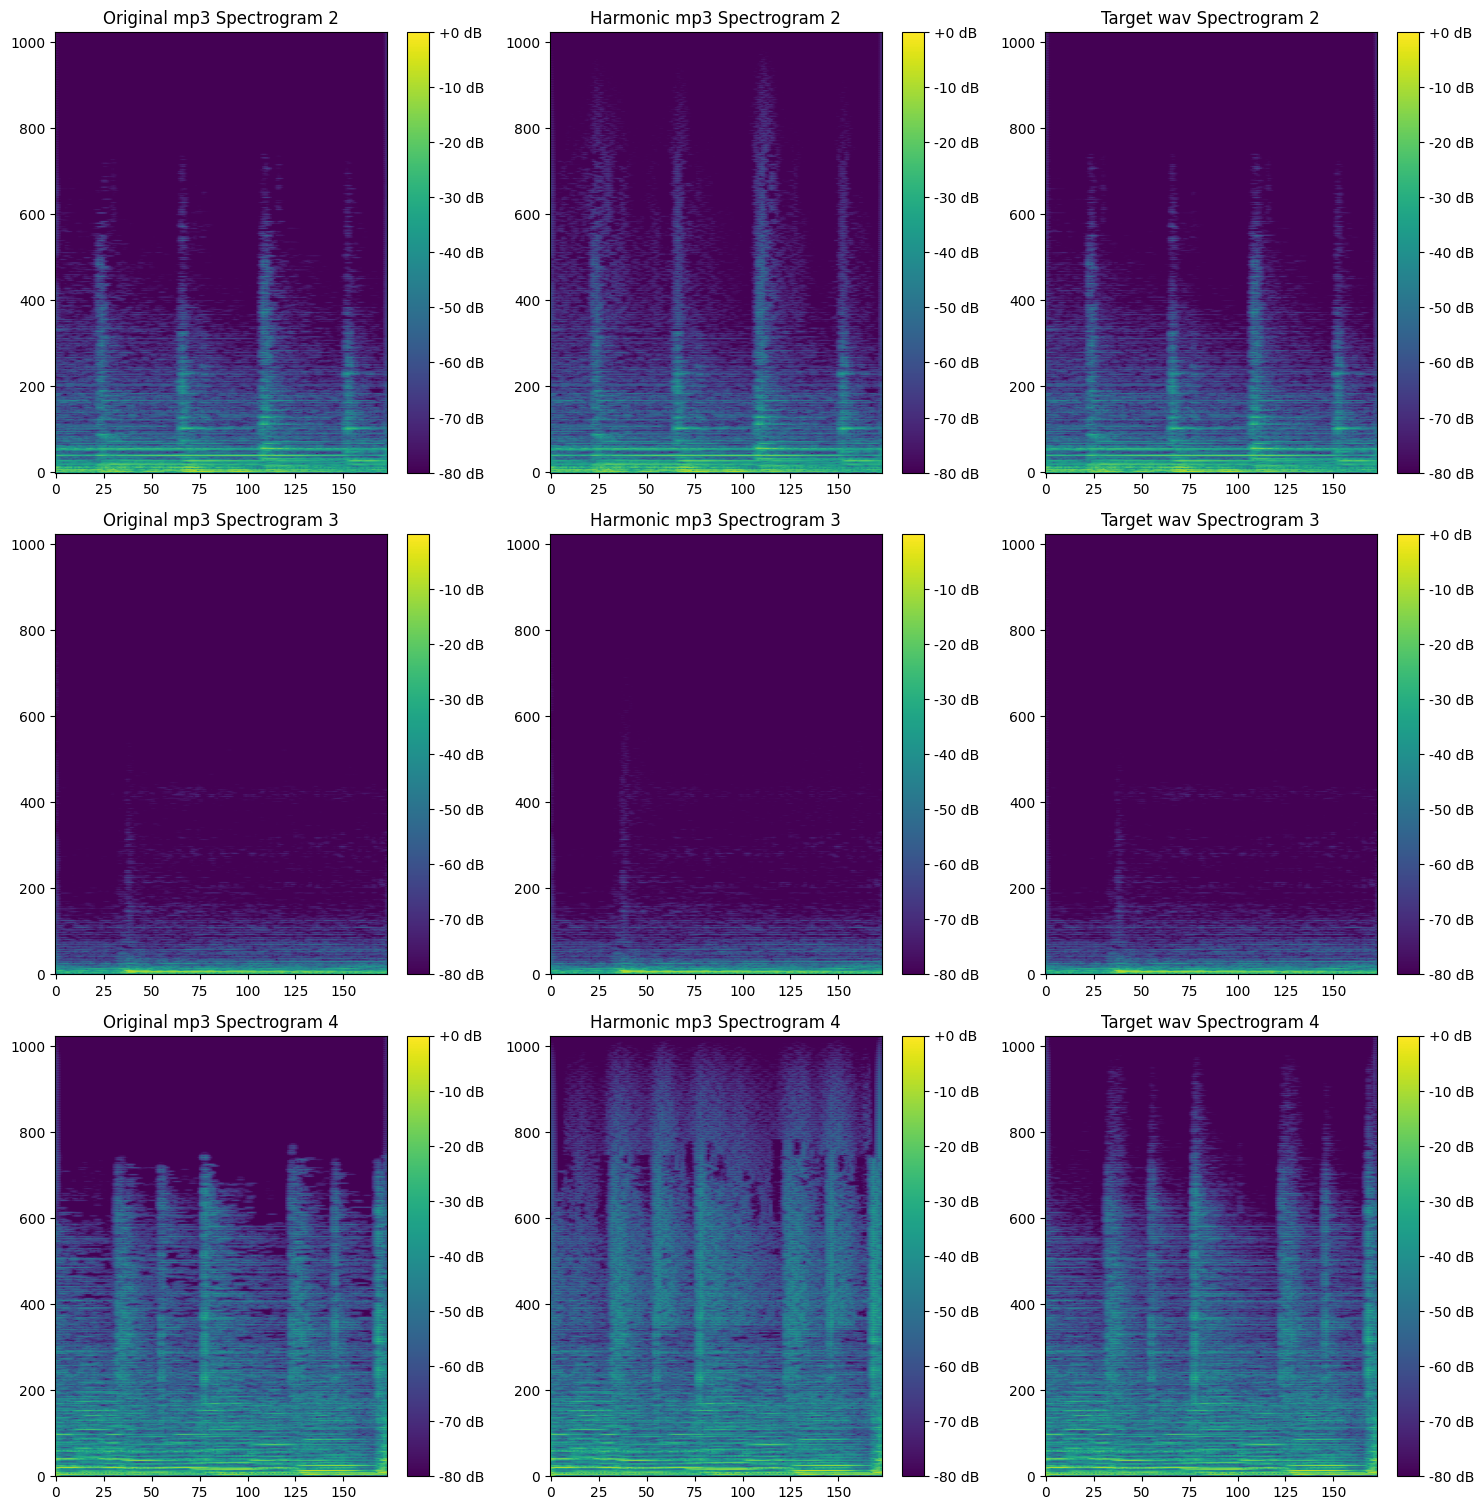

(2049, 87)


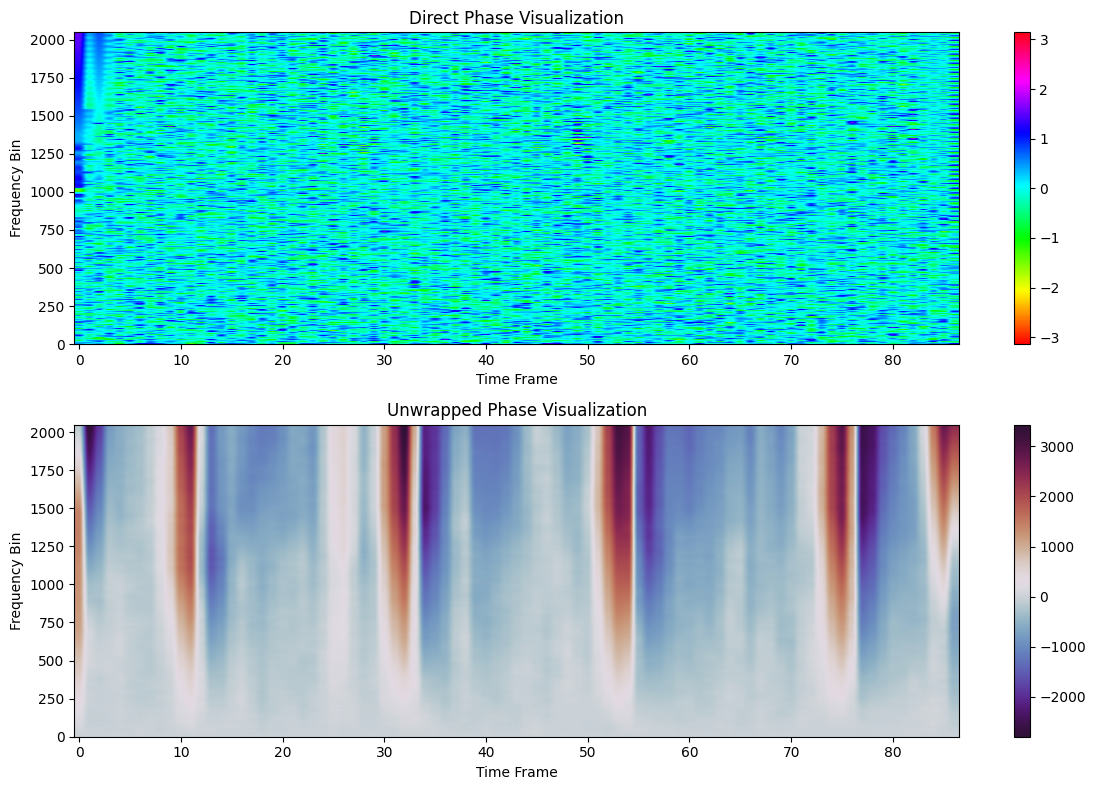

(2049, 87)


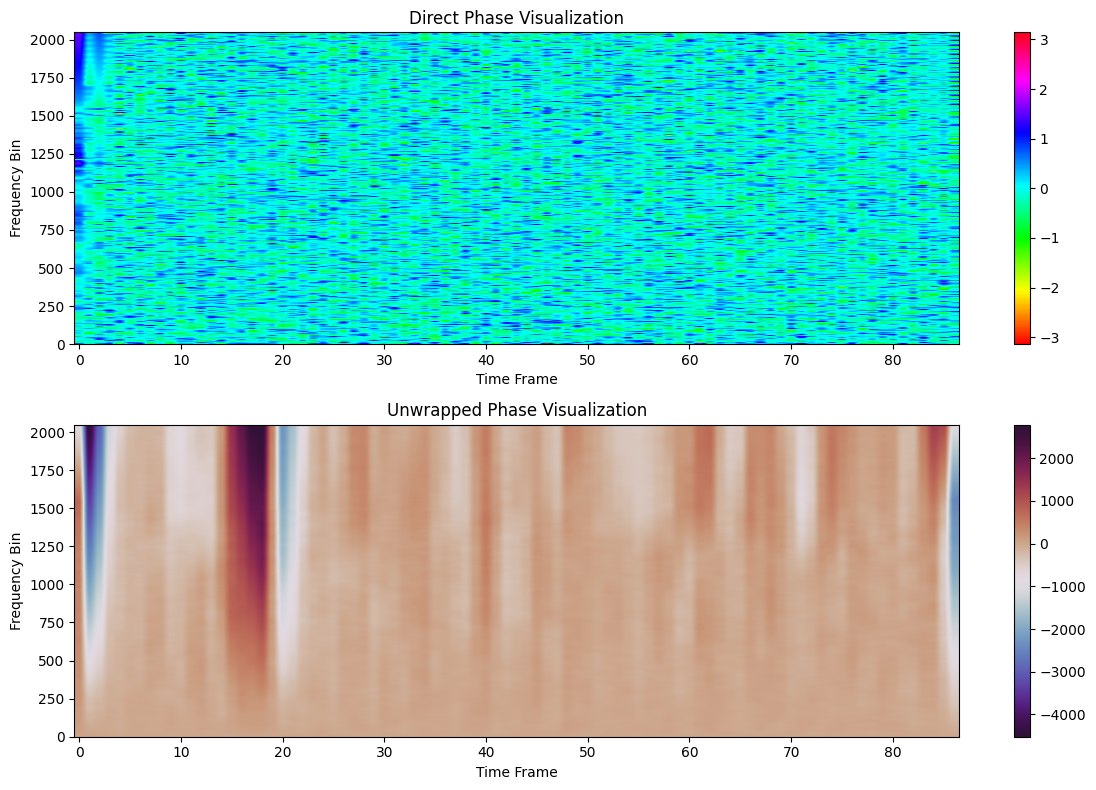

(2049, 87)


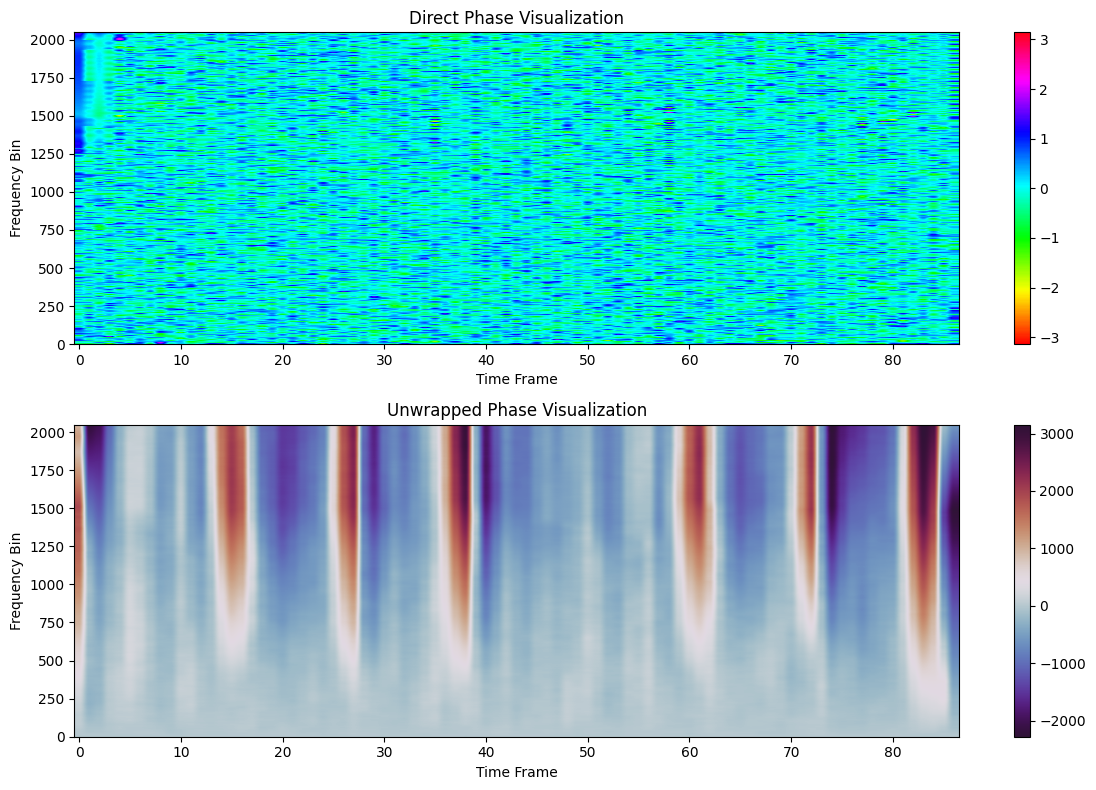

(2049, 87)


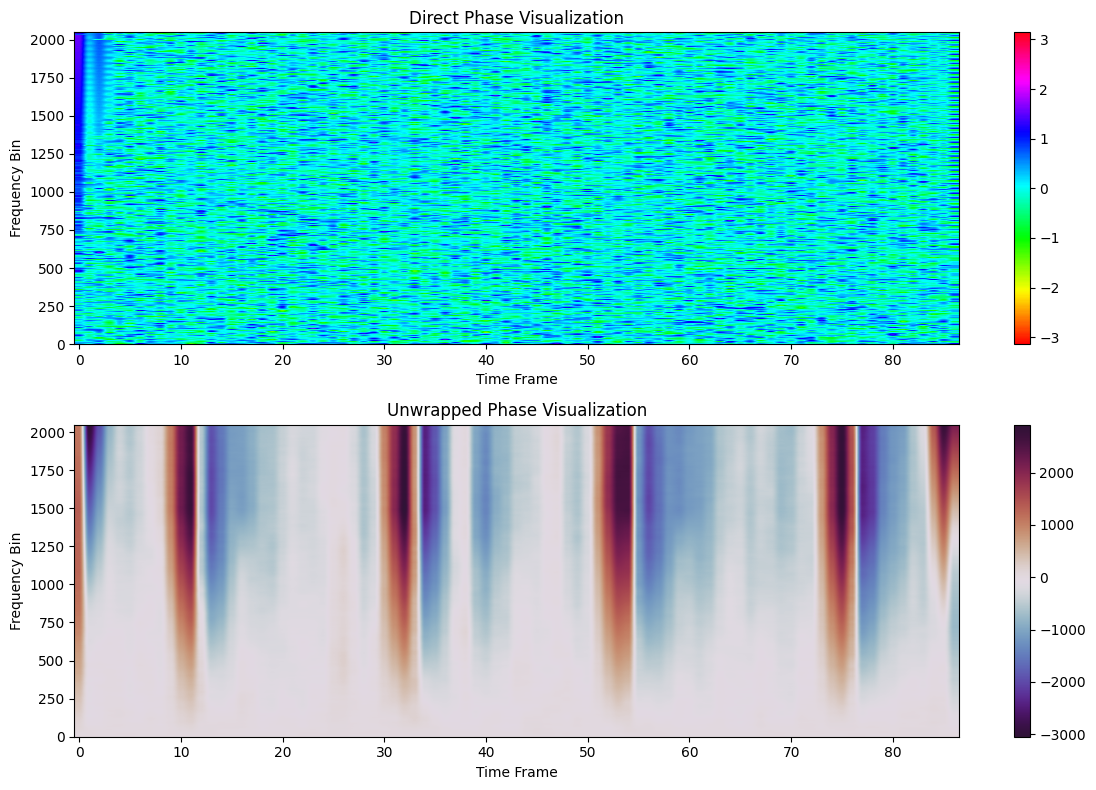

(2049, 87)


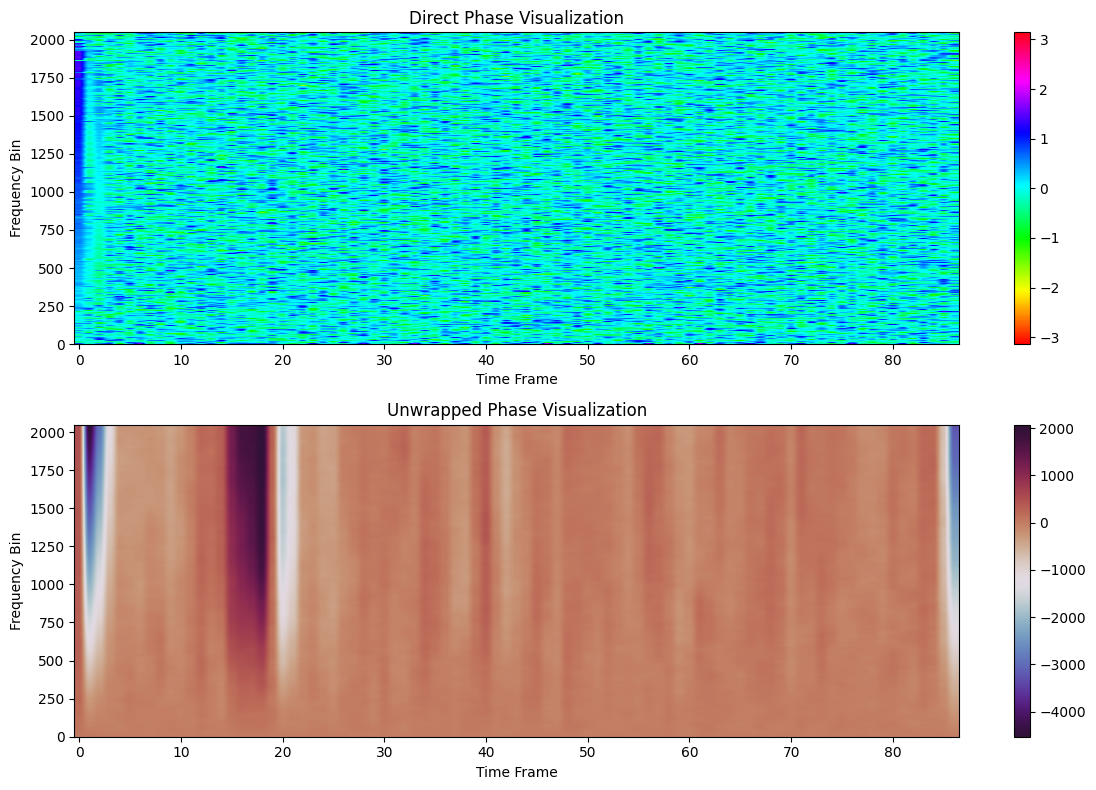

(2049, 87)


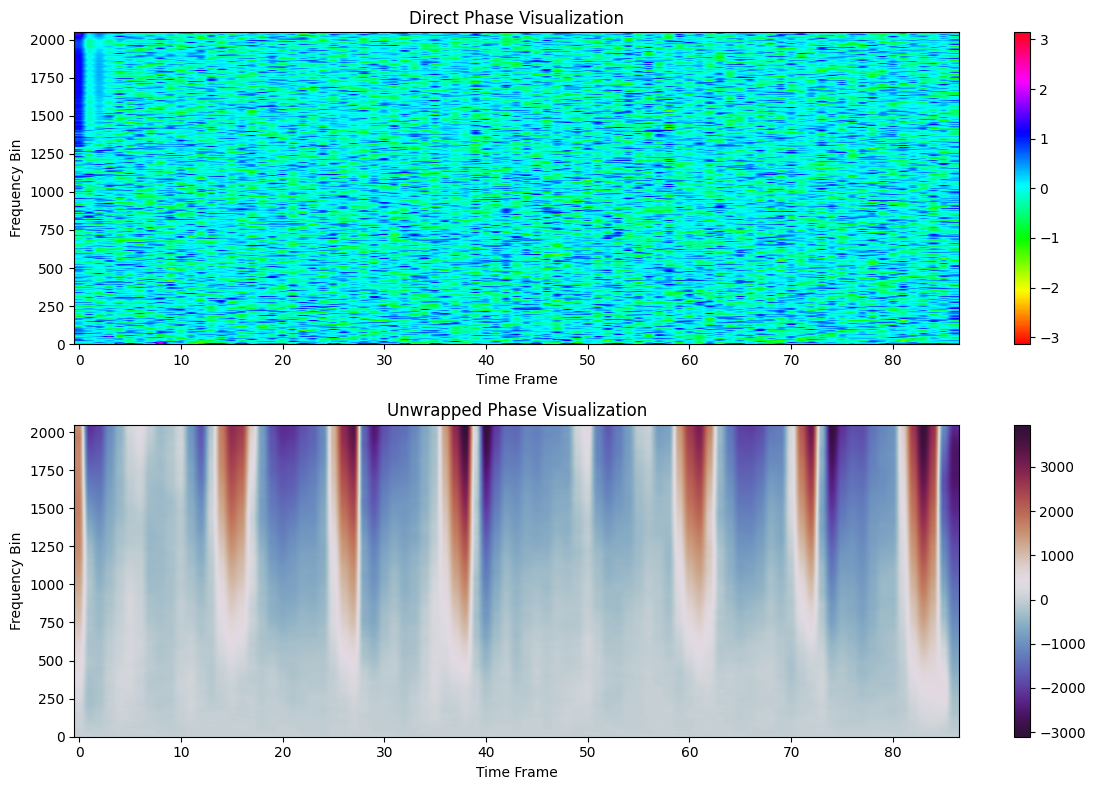

(2049, 87)


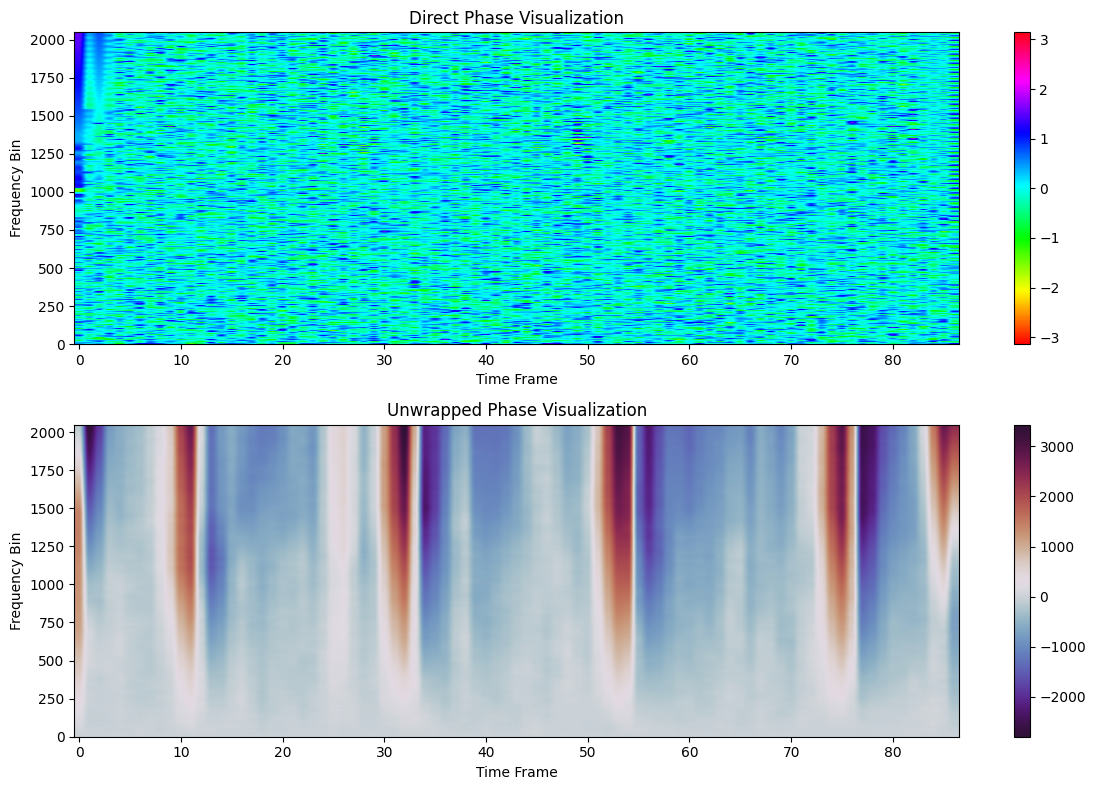

(2049, 87)


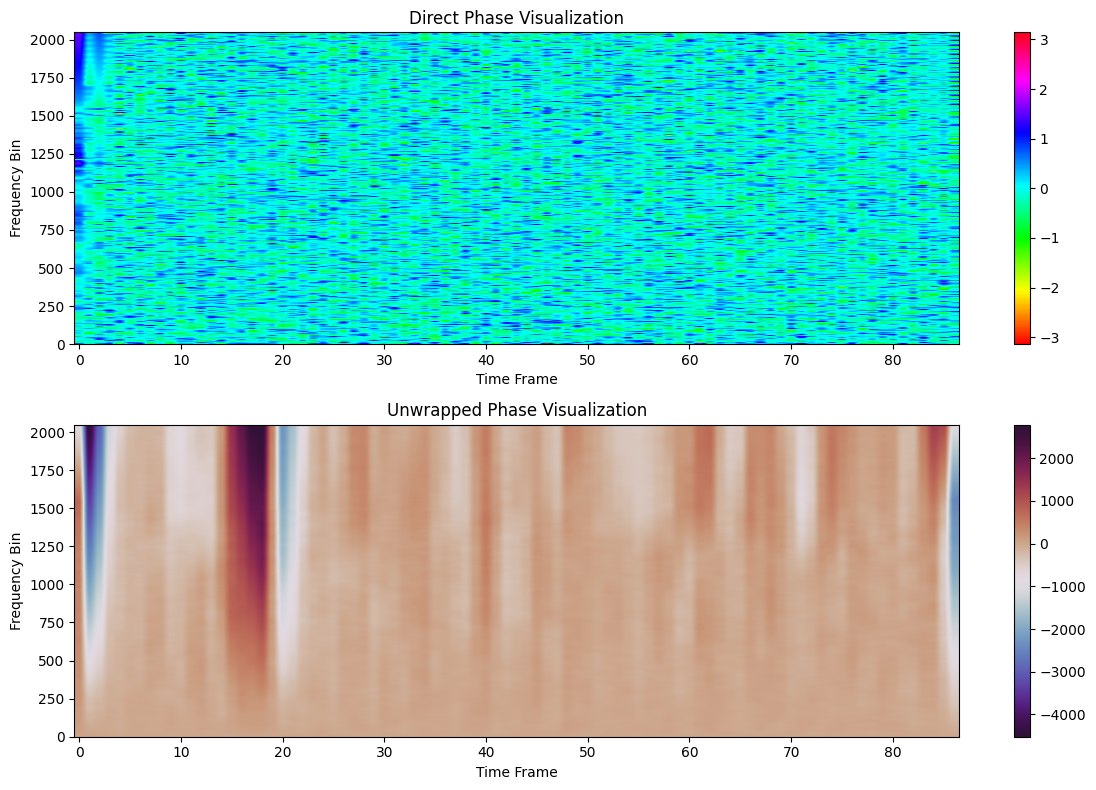

(2049, 87)


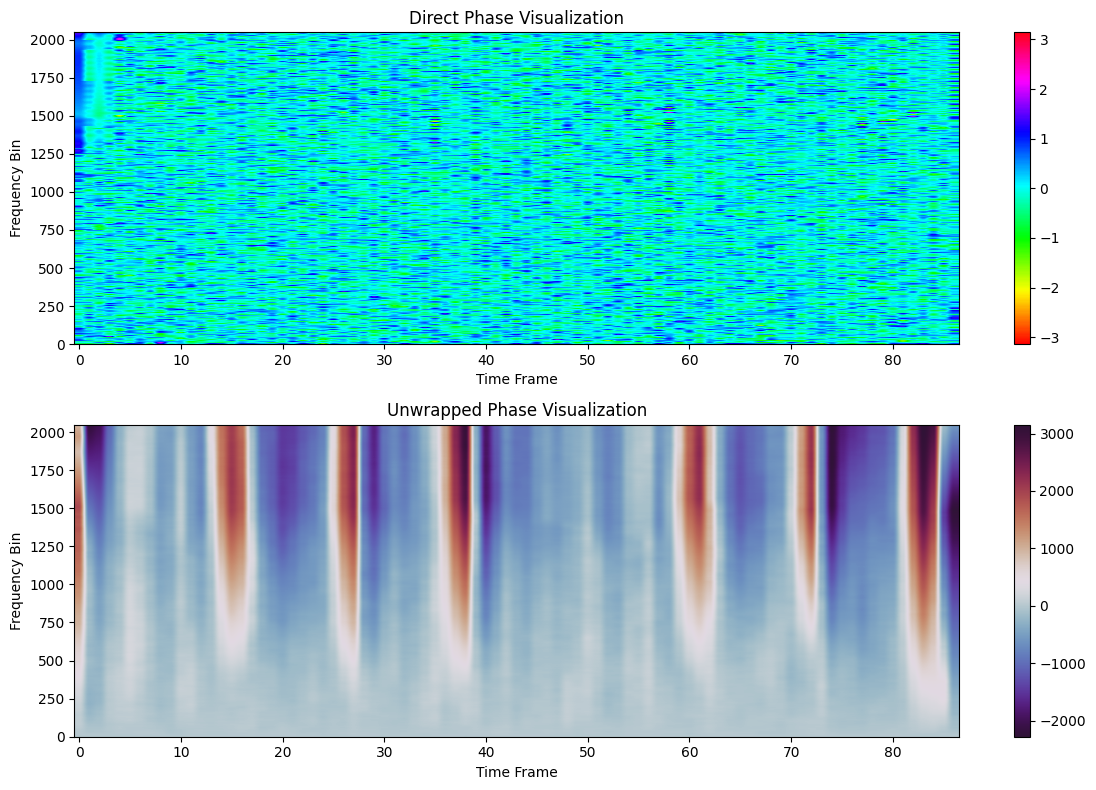

In [ ]:


def normalize(y):
    """Normalize a numpy array to the range [0, 1]."""
    y_min, y_max = y.min(), y.max()
    if y_max == y_min:
        # Avoid division by zero
        return np.ones_like(y)
    return (y - y_min) / (y_max - y_min)


def extrapolate_frequency_content(data, boundary=700, degree=3, decay_rate=0.999, load_data=False):
    if load_data:
      print("loading transients")
      modified_data = np.load("coeffs/transients.npy", allow_pickle=True)
      return modified_data

    magnitude = data[..., 0]
    phase = data[..., 1]

    modified_magnitude = np.copy(magnitude)
    modified_phase = np.copy(phase)



    for i in tqdm.tqdm(range(magnitude.shape[0]), total=magnitude.shape[0], desc="adding frequencies to transients"):  # Iterate over examples
        for j in range(magnitude.shape[2]):  # Iterate over frames
            frame_magnitude = magnitude[i, :, j]

            # Get known lower frequencies and their indices
            x = np.arange(boundary)
            y = frame_magnitude[:boundary]

            # Fit a polynomial to the known data
            coeffs = np.polyfit(x, y, degree)
            polynomial = np.poly1d(coeffs)

            # Extrapolate to the higher frequency bins
            x_high = np.arange(boundary, magnitude.shape[1])
            y_high = polynomial(x_high)

            # Normalize the extrapolated values to [0, 1]
            y_high_normalized = normalize(y_high)

            # Determine the starting magnitude for exponential decay
            avg_bins = 16
            start_magnitude = np.max(frame_magnitude[boundary-avg_bins:boundary])
            y_high_masked = y_high_normalized * start_magnitude
            decay_length = len(y_high_masked)
            decay_factor = np.power(decay_rate, np.arange(decay_length))

            # Apply the decay to the extrapolated values
            y_high_masked *= decay_factor


            # Update the frame with the masked extrapolated values
            condition = modified_magnitude[i, boundary:, j] != 0  # Identify non-zero values
            avg_values = (modified_magnitude[i, boundary:, j] + y_high_masked) / 2  # Compute average values

            modified_magnitude[i, boundary:, j] = np.where(condition, avg_values, y_high_masked)


    modified_phase = phase
    # Combine magnitude and modified phase (phase remains unchanged)
    modified_data = np.stack([modified_magnitude, modified_phase], axis=-1)
    print("saving extended transients")
    np.save("coeffs/transients.npy", modified_data)
    print("saved modified data")
    return modified_data


# After first init, change load_data back to True
harmonic_mp3 = extrapolate_frequency_content(combined_mp3, load_data=True)


# Convert your magnitude and phase to complex spectrogram
mp3_spectrograms = combined_mp3[0:10][...,0] * np.exp(1j * combined_mp3[0:10][...,1])
mp3_audios_no_harmonics = [librosa.istft(mp3_spec) for mp3_spec in mp3_spectrograms]
harmonic_spectrograms = harmonic_mp3[0:10][...,0] * np.exp(1j * harmonic_mp3[0:10][...,1])
harmonic_audios = [librosa.istft(harm_spec) for harm_spec in harmonic_spectrograms]
wav_spectrograms = combined_wav[0:10][...,0] * np.exp(1j * combined_wav[0:10][...,1])
wav_audios = [librosa.istft(wav_spec) for wav_spec in wav_spectrograms]

num_samples = 11
plt.figure(figsize=(15, 5 * num_samples))  # Adjust size as necessary
i = 1
for mp3_audio, harmonic_audio, wav_audio in zip(mp3_audios_no_harmonics, harmonic_audios, wav_audios):
    # Original mp3 without harmonics
    plt.subplot(num_samples, 3, 3 * i + 1)
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(mp3_audio)), ref=np.max)
    plt.imshow(D_original, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Original mp3 Spectrogram {i+1}")

    # mp3 with added harmonics
    plt.subplot(num_samples, 3, 3 * i + 2)
    D_harmonic = librosa.amplitude_to_db(np.abs(librosa.stft(harmonic_audio)), ref=np.max)
    plt.imshow(D_harmonic, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Harmonic mp3 Spectrogram {i+1}")

    # Target wav
    plt.subplot(num_samples, 3, 3 * i + 3)
    D_target = librosa.amplitude_to_db(np.abs(librosa.stft(wav_audio)), ref=np.max)
    plt.imshow(D_target, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Target wav Spectrogram {i+1}")
    i += 1
plt.tight_layout()
plt.show()
def plot_phase(data, sr, hop_length):
    print(data.shape)
    plt.figure(figsize=(12, 8))

    # 1. Direct Phase Visualization
    plt.subplot(2, 1, 1)
    plt.imshow(data, aspect='auto', origin='lower', cmap='hsv')
    plt.colorbar()
    plt.title("Direct Phase Visualization")
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency Bin")

    # 2. Unwrapped Phase Visualization
    unwrapped_phase = np.unwrap(data, axis=0)  # Unwrap along frequency axis
    plt.subplot(2, 1, 2)
    plt.imshow(unwrapped_phase, aspect='auto', origin='lower', cmap='twilight_shifted')
    plt.colorbar()
    plt.title("Unwrapped Phase Visualization")
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency Bin")

    plt.tight_layout()
    plt.show()

for data in combined_mp3[0:3]:
    plot_phase(data[..., 1], sr=44100, hop_length=512)

for data in combined_wav[0:3]:
    plot_phase(data[..., 1], sr=44100, hop_length=512)

for data in harmonic_mp3[0:3]:
    plot_phase(data[..., 1], sr=44100, hop_length=512)

In [ ]:

# print("Finished combining magnitude and phase")
# nan_mask = np.isnan(harmonic_mp3)

# # Replace NaN values with 0
# harmonic_mp3[nan_mask] = 0

combined_mp3 = harmonic_mp3
pred_mag, true_mag, pred_phase, true_phase = normalize_data(combined_mp3, combined_wav, load_data=False)
print("Finished normalizing data")
combined_mp3[..., 0] = pred_mag
combined_wav[..., 0] = true_mag
combined_mp3[..., 1] = pred_phase
combined_wav[..., 1] = true_phase
# avg_magnitude_wav = np.mean(combined_wav[..., 0], axis=0)
# avg_magnitude_mp3 = np.mean(combined_mp3[..., 0], axis=0)
# print("Finished averaging magnitude")
# magnitude_mask = np.where(avg_magnitude_wav > avg_magnitude_mp3, 1.0, 1.0)
# # TRY TURNING THIS ON/FIX FOR OTHER MASKS
# # magnitude_mask = 1.0 - combined_mp3[..., 0]
# phase_mask = magnitude_mask
# combined_mask = np.stack([magnitude_mask, phase_mask], axis=-1)


Finished normalizing data


In [ ]:
def custom_mse():
    def loss(y_true, y_pred):
        # Split the magnitude and phase components
        y_true_mag = y_true[..., 0:1]
        y_pred_mag = y_pred[..., 0:1]


        # y_true_phase = y_true[..., 1:2]
        # y_pred_phase = y_pred[..., 1:2]

        # Compute the LSD for magnitude
        # epsilon = 1e-5

        # Compute the squared difference
        diff = tf.norm(y_true_mag - y_pred_mag)

        # diff = tf.square(diff)

        lsd_mag = tf.reduce_mean(diff)

        # Compute the masked MSE for phase
        # Compute the cyclic phase difference
        # y_true_phase_rad = 2 * np.pi * y_true_phase - np.pi
        # y_pred_phase_rad = 2 * np.pi * y_pred_phase - np.pi
        # phase_diff = tf.sin(y_true_phase_rad) - tf.sin(y_pred_phase_rad)  # using sine to get the cyclic difference
        # masked_phase_diff = phase_diff
        # mse_phase = tf.reduce_mean(tf.square(masked_phase_diff))



        # Combine the losses
        combined_loss = lsd_mag # + mse_phase

        return combined_loss

    return loss

def scaled_tanh(x):
    return (tf.math.tanh(x) + 1) / 2

def UResNet():
    def residual_encoder_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation="relu", strides=(1,1)):
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                                   kernel_initializer="he_normal", padding="same", strides=strides)(input_tensor)
        if batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.PReLU()(x)


        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                                   kernel_initializer="he_normal", padding="same")(x)
        if batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.PReLU()(x)


        shortcut = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(1,1),
                                          strides=strides, padding="same")(input_tensor)
        if batchnorm:
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)

        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.PReLU()(x)

        return x

    def decoder_block(input_tensor, skip_tensor, n_filters, kernel_size=3, batchnorm=True, activation="relu"):
        x = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(3, 3), strides=(2, 2), padding="same")(input_tensor)
        # x = tf.keras.layers.Dropout(0.1)(x)
        x_shape = tf.shape(x)[1:3]
        skip_tensor = tf.image.resize_with_crop_or_pad(skip_tensor, x_shape[0], x_shape[1])
        x = tf.keras.layers.concatenate([skip_tensor, x], axis=-1)
        x = residual_encoder_block(x, n_filters, kernel_size, batchnorm, activation)
        return x

    inputs = tf.keras.layers.Input(shape=(1025,87,2))
    original_phase = tf.keras.layers.Lambda(lambda x: x[..., 1:])(inputs)
    x_mag = tf.keras.layers.Lambda(lambda x: x[..., 0:])(inputs)

    x_mag = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same')(x_mag)
    x_mag = tf.keras.layers.PReLU()(x_mag)
    x_mag = tf.keras.layers.BatchNormalization()(x_mag)

    # original_phase = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same')(original_phase)
    # original_phase = tf.keras.layers.PReLU()(original_phase)
    # original_phase = tf.keras.layers.BatchNormalization()(original_phase)

    # Encoder (Downsampling using strided convolutions) - Magnitude
    ## \/ \/ \/ THIS WAS CHANGED (TURNED ON) \/ \/ \/
    #x_mag = tf.keras.layers.GaussianNoise(0.1)(x_mag) # Play with this
    c1_mag = residual_encoder_block(x_mag, 64, strides=2)
    c2_mag = residual_encoder_block(c1_mag, 128, strides=2)
    c3_mag = residual_encoder_block(c2_mag, 256, strides=2)
    c4_mag = residual_encoder_block(c3_mag, 512, strides=2)
    c5_mag = residual_encoder_block(c4_mag, 1024, strides=2)

    # Decoder (Upsampling) - Magnitude
    u5_mag = decoder_block(c5_mag, c4_mag, 1024)
    u4_mag = decoder_block(u5_mag, c3_mag, 512)
    u3_mag = decoder_block(u4_mag, c2_mag, 256)
    u2_mag = decoder_block(u3_mag, c1_mag, 128)
    u1_mag = decoder_block(u2_mag, x_mag, 64)  # Here, we're using x_mag as the skip connection

    # Output layer - Magnitude
    output_mag = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u1_mag)


    # Encoder (Downsampling using strided convolutions) - Phase

    # c1_phase = residual_encoder_block(original_phase, 64, strides=2, activation=None)
    # c2_phase = residual_encoder_block(c1_phase, 128, strides=2, activation=None)
    # c3_phase = residual_encoder_block(c2_phase, 256, strides=2, activation=None)
    # c4_phase = residual_encoder_block(c3_phase, 512, strides=2, activation=None)
    # c5_phase = residual_encoder_block(c4_phase, 1024, strides=2, activation=None)

    # # Decoder (Upsampling) - Phase
    # u5_phase = decoder_block(c5_phase, c4_phase, 1024, activation=None)
    # u4_phase = decoder_block(u5_phase, c3_phase, 512, activation=None)
    # u3_phase = decoder_block(u4_phase, c2_phase, 256, activation=None)
    # u2_phase = decoder_block(u3_phase, c1_phase, 128, activation=None)
    # u1_phase = decoder_block(u2_phase, original_phase, 64, activation=None)

    # # Output layer - Phase

    # output_phase = tf.keras.layers.Conv2D(1, (1, 1), activation=None)(u1_phase)
    # output_phase = tf.keras.layers.PReLU()(output_phase)

    desired_shape = (1025, 87)

    # Cropping the magnitude output
    output_mag_cropped = tf.keras.layers.Lambda(
        lambda x: tf.image.crop_to_bounding_box(x,
                                                offset_height=0,
                                                offset_width=0,
                                                target_height=desired_shape[0],
                                                target_width=desired_shape[1])
    )(output_mag)

    # # Cropping the phase output
    # output_phase_cropped = tf.keras.layers.Lambda(
    #     lambda x: tf.image.crop_to_bounding_box(x,
    #                                             offset_height=0,
    #                                             offset_width=0,
    #                                             target_height=desired_shape[0],
    #                                             target_width=desired_shape[1])
    # )(output_phase)

    # Then combine them
    combined_output_cropped = tf.keras.layers.Concatenate(axis=-1)([output_mag_cropped, original_phase])

    model = tf.keras.models.Model(inputs=[inputs], outputs=[combined_output_cropped])
    model.compile(optimizer='adam', loss=custom_mse(), metrics=['accuracy',tf.keras.metrics.MeanSquaredError()])
    model.summary()
    return model



def train_model(mp3_data, wav_data):
    ResNet = UResNet()
    print("Model Built")

    print("Starting fitting")
    ResNet.fit(mp3_data, wav_data, validation_split=0.1, epochs=4,batch_size=1, shuffle=True) #shuffle=True?

    print("Finished fitting")
    return ResNet

print("Initializing model")
ResNet = train_model(combined_mp3, combined_wav)

Initializing model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1025, 87, 2)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 1025, 87, 2)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1025, 87, 64)         1216      ['lambda_1[0][0]']            
                                                                                                  
 p_re_lu (PReLU)             (None, 1025, 87, 64)         5707200   ['conv2d[0][0]']              
                                                                           

In [ ]:
## IDEAS:
#  -- try mse as loss
#  -- Increase num epochs / tweak learning rate
#  -- Up n_fft to 4096 and/or longer training examples
#  -- Experiment with just using the mp3 phases?

In [ ]:
print("Predicting")
batch_size = 2
num_samples = len(combined_mp3)
num_batches = int(np.ceil(num_samples / batch_size))

reconstructed_audios = []
true_audios = []

def denormalize_mag(arr):
  return np.exp(arr) - 1

for i in range(num_batches):
  if i > 20:
    break
  start_idx = i * batch_size
  end_idx = start_idx + batch_size

  batch_mp3 = combined_mp3[start_idx:end_idx]
  batch_wav = combined_wav[start_idx:end_idx]



  differences_predicted = ResNet.predict(batch_mp3)
  batch_pred_mag = denormalize_mag(batch_mp3[...,0])

  batch_pred_phase = denormalize_phase(batch_mp3[...,1])
  # Splitting the differences_predicted into magnitude and phase
  differences_mag = differences_predicted[..., 0]
  differences_phase = differences_predicted[..., 1]

  # differences_mag *= magnitude_mask
  # differences_phase *= phase_mask

  # Denormalize magnitude and phase for batch_mp3
  differences_mag = denormalize_mag(differences_mag)
  differences_phase = denormalize_phase(differences_phase)

  # Construct the denormalized batch_mp3

  # Denormalize magnitude and phase for batch_wav
  batch_true_mag = denormalize_mag(batch_wav[..., 0])
  batch_true_phase = denormalize_phase(batch_wav[..., 1])

  # Apply the predicted differences to the mp3 magnitude and phase

  pre_spectrograms = batch_pred_mag * np.exp(1j * batch_pred_phase)
  pre_audios = [librosa.istft(pre_spectrogram) for pre_spectrogram in pre_spectrograms]
  true_spectrograms = batch_true_mag * np.exp(1j * batch_true_phase)
  batch_true_audios = [librosa.istft(true_spectrogram) for true_spectrogram in true_spectrograms]
  true_audios.extend(batch_true_audios)


  model_spectrograms = differences_mag * np.exp(1j * differences_phase)
  model_pred_audios = [librosa.istft(model_spectrogram) for model_spectrogram in model_spectrograms]
  difference_audios = [true_audio - pred_audio for true_audio, pred_audio in zip(batch_true_audios, model_pred_audios)]
  batch_reconstructed_audios = [pred_audio + pre_audio for pre_audio, pred_audio in zip(pre_audios, model_pred_audios)]
  reconstructed_audios.extend(batch_reconstructed_audios)

  # Visualization
  if True:
    if not os.path.exists('audiofiles/data/original'):
      os.makedirs('audiofiles/data/original')
    if not os.path.exists('audiofiles/data/difference'):
      os.makedirs('audiofiles/data/difference')
    if not os.path.exists('audiofiles/data/pred'):
      os.makedirs('audiofiles/data/pred')
    if not os.path.exists('audiofiles/data/reconstructed'):
      os.makedirs('audiofiles/data/reconstructed')
      for j, (recon_audio, diff_audio, pred_audio, mp3) in enumerate(zip(batch_reconstructed_audios,
                                                                          difference_audios, model_pred_audios, pre_audios)):
          idx = i * batch_size + j
          visualize_results(true_audios[idx], recon_audio, diff_audio, pred_audio, mp3)
          real_diff = true_audios[idx] - mp3
          save_audios(true_audios[idx],
                  diff_audio,
                  pred_audio,
                  recon_audio,
                  mp3,
                  f"/content/drive/MyDrive/audiofiles/data/original/true_wav_{idx}.wav",
                  f"/content/drive/MyDrive/audiofiles/data/difference/difference_{idx}.wav",
                  f"/content/drive/MyDrive/audiofiles/data/pred/pred_{idx}.wav",
                  f"/content/drive/MyDrive/audiofiles/data/reconstructed/reconstructed_{idx}.wav",
                  f"/content/drive/MyDrive/audiofiles/data/original/mp3_{idx}.wav")
  i += 1

